In [160]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

import scipy.stats as scs
from scipy.optimize import minimize
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


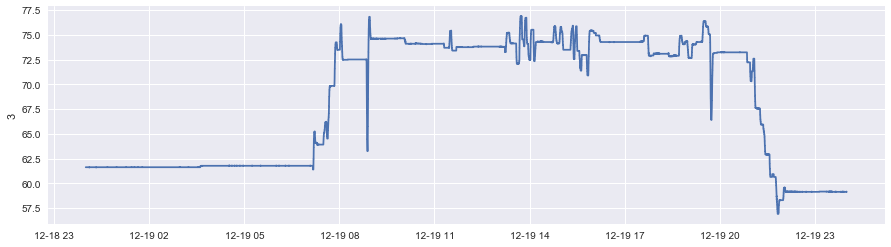

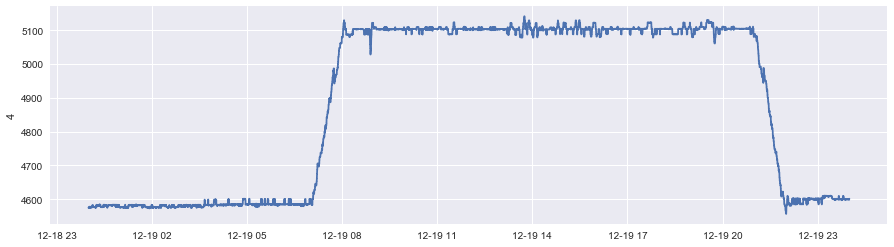

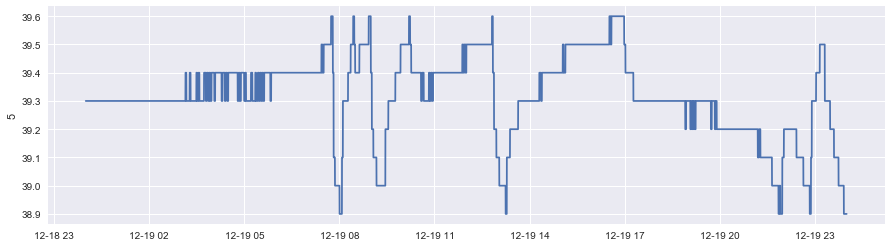

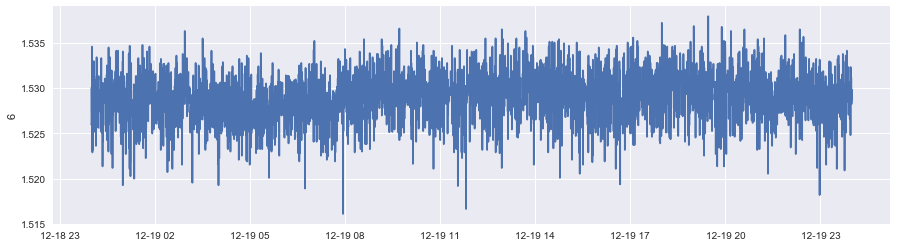

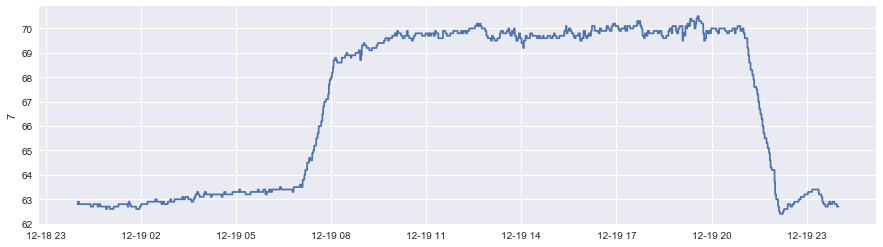

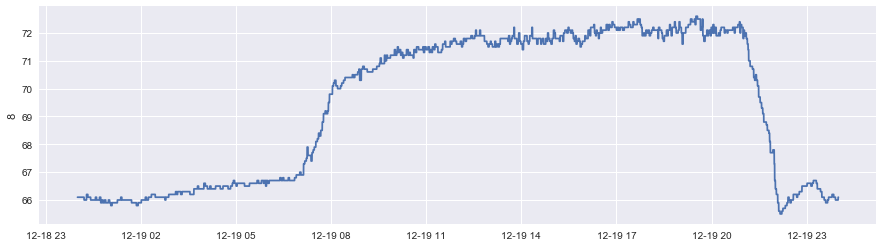

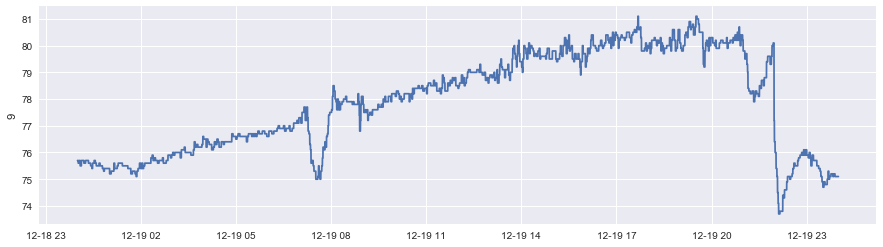

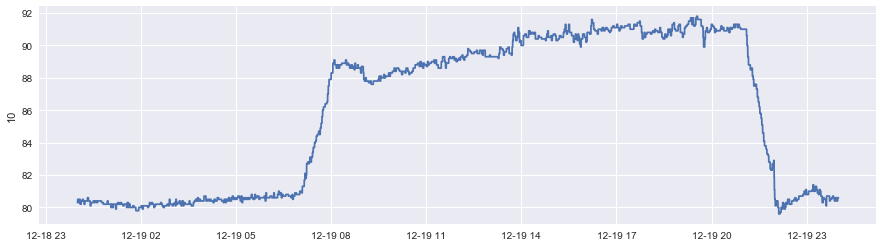

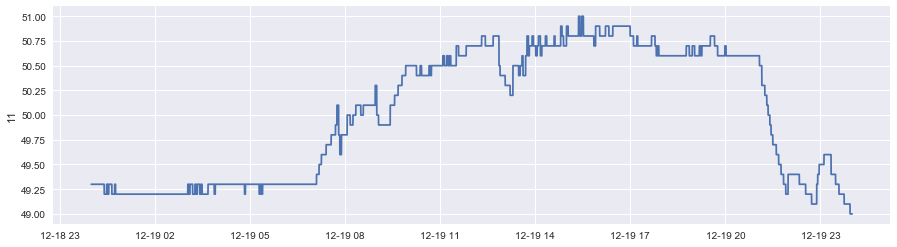

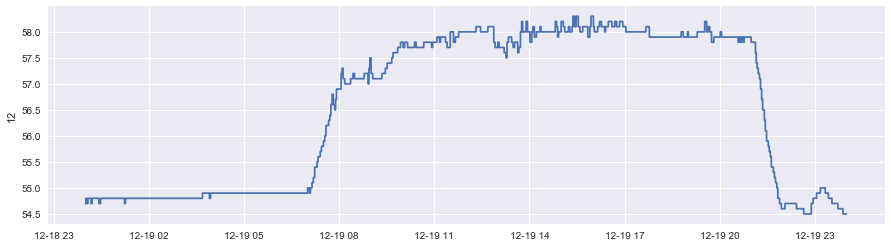

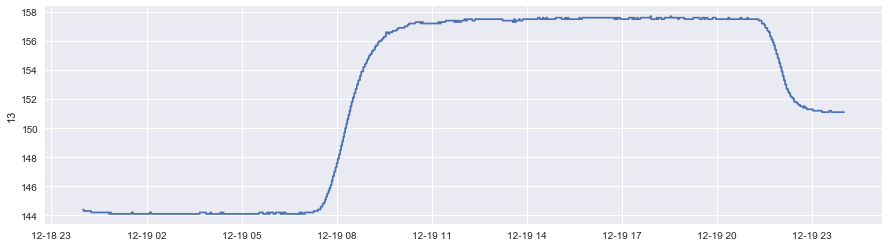

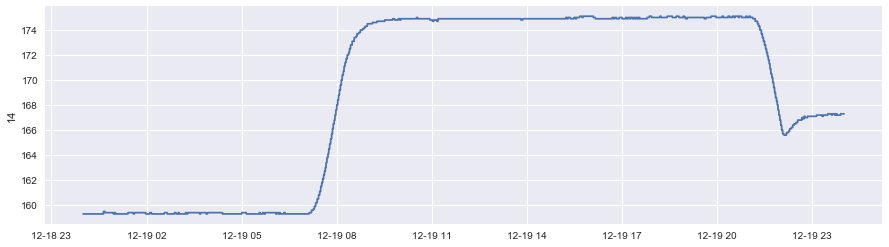

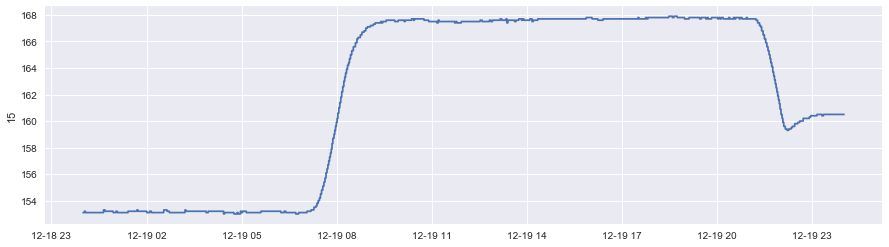

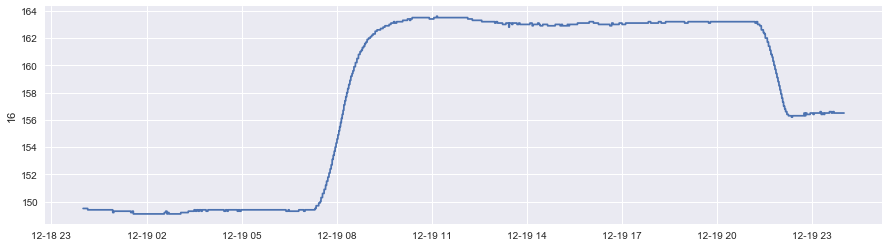

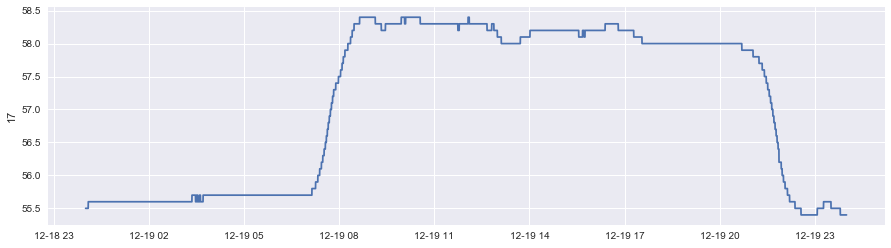

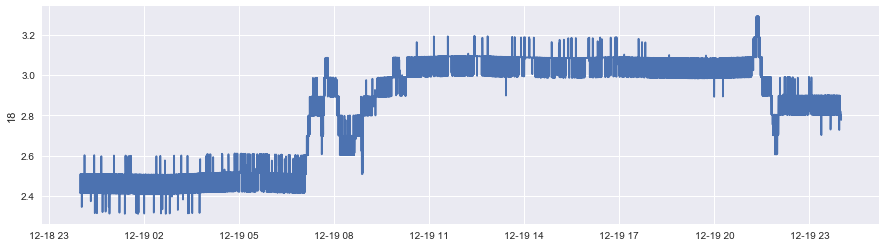

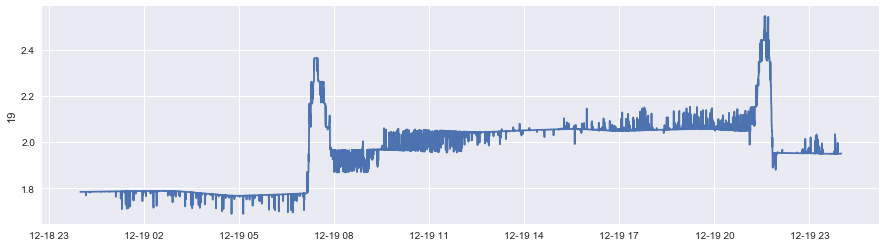

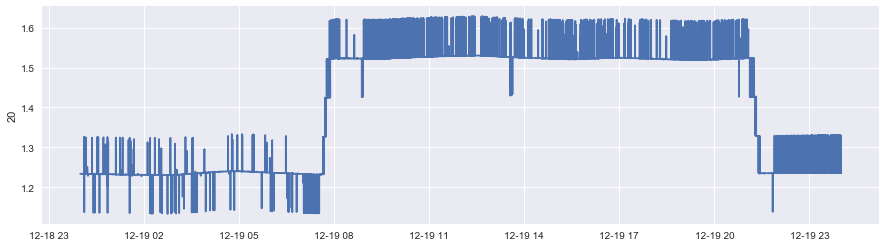

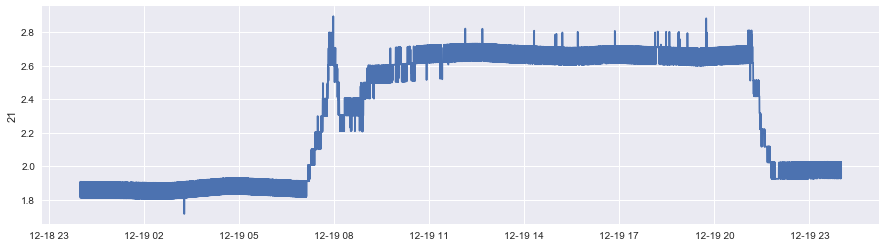

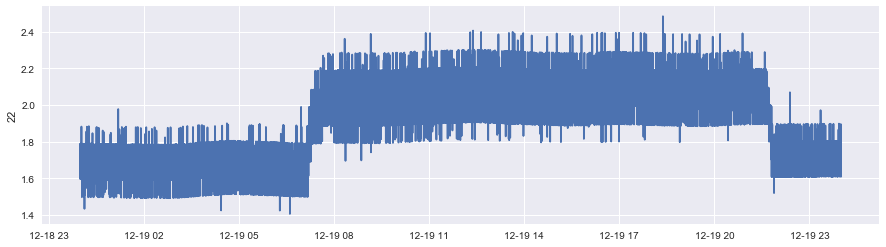

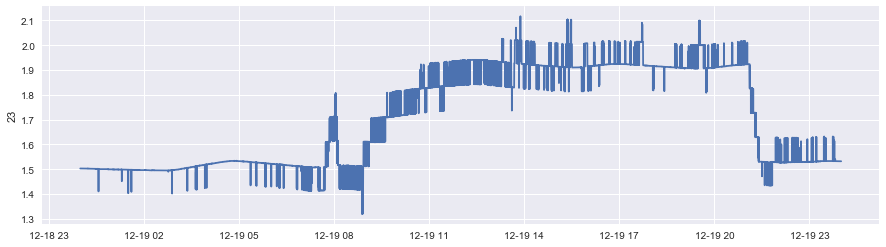

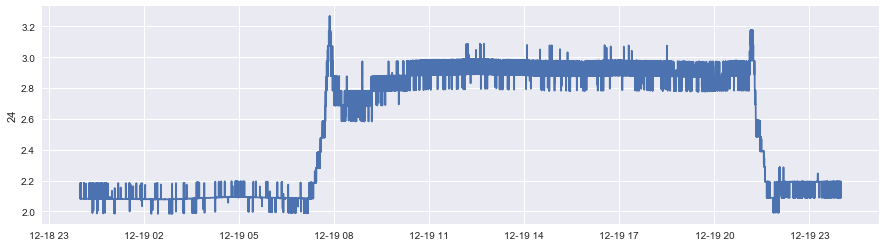

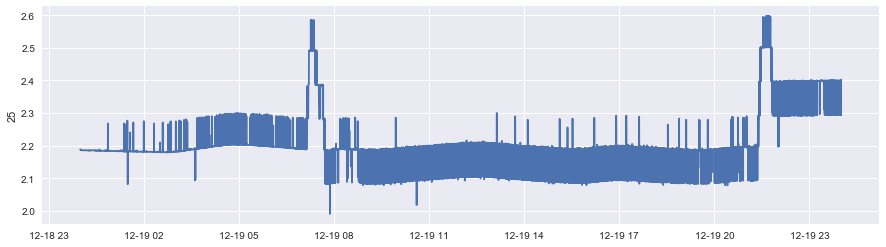

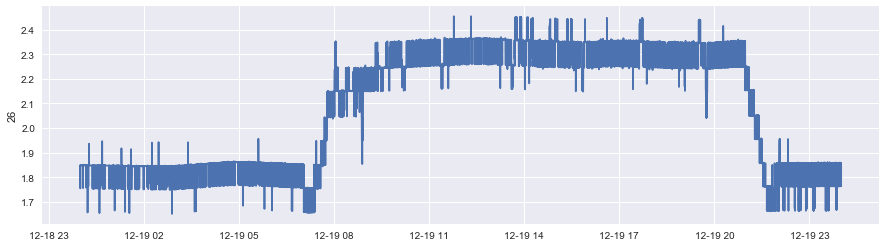

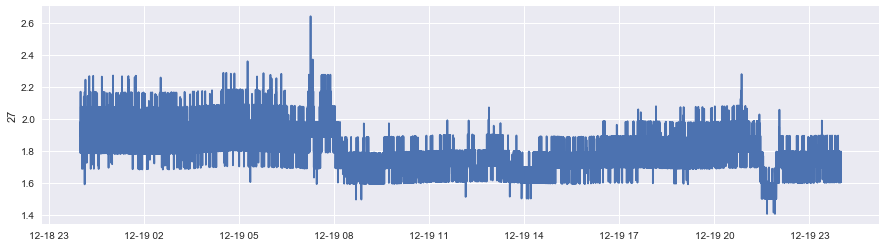

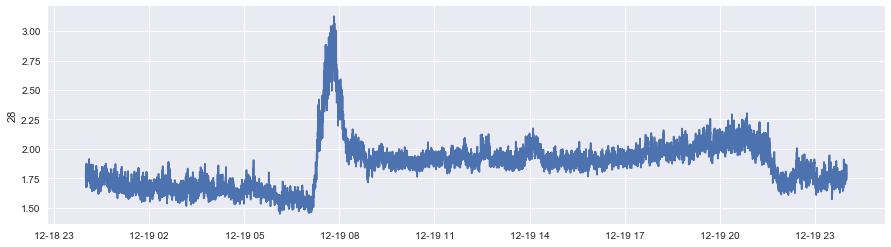

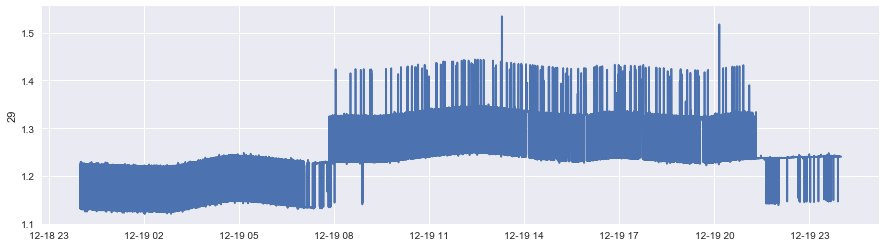

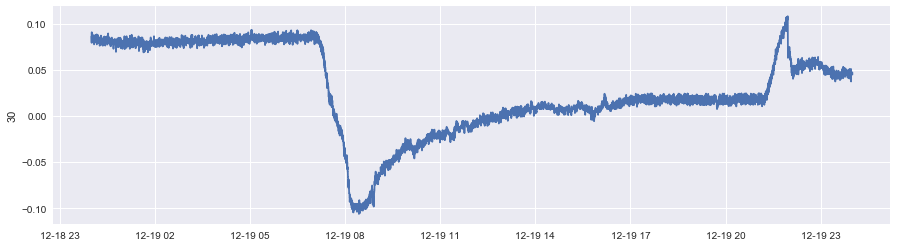

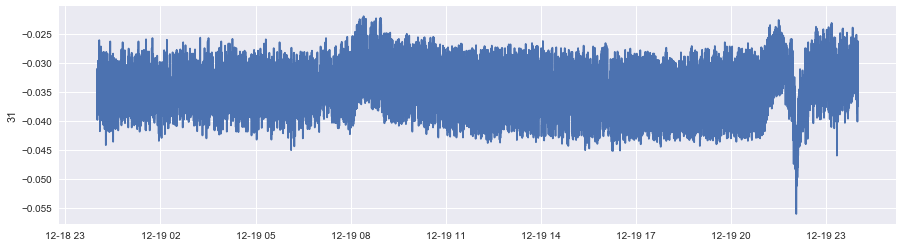

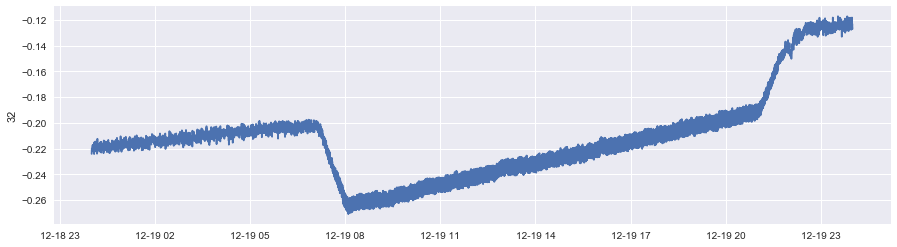

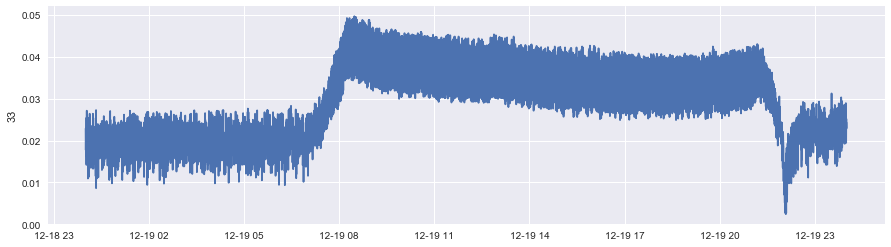

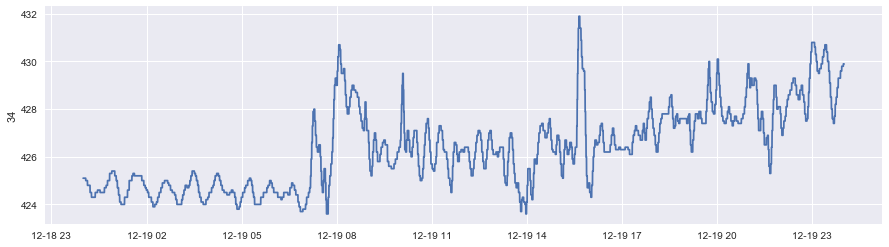

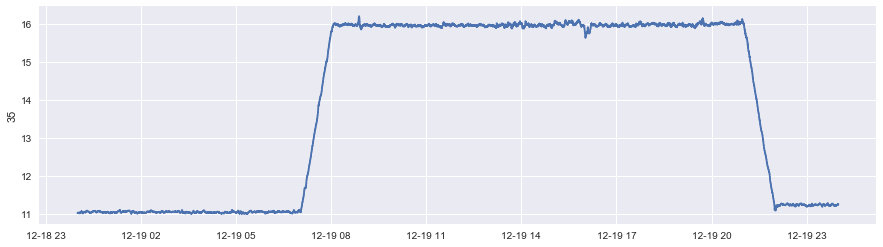

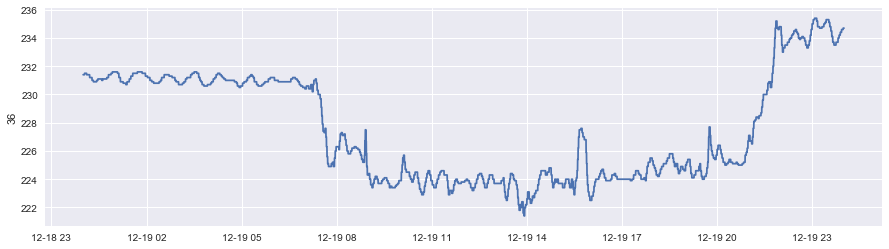

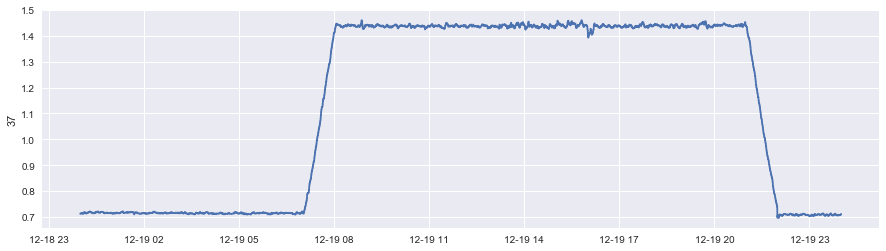

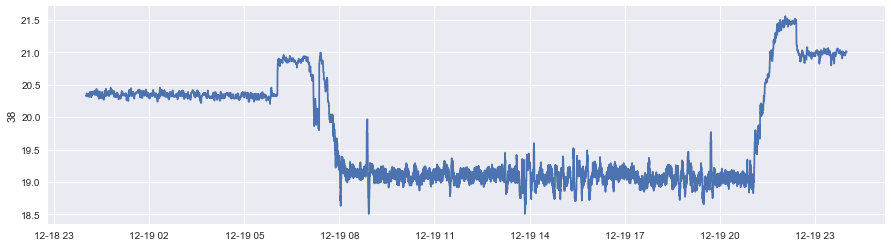

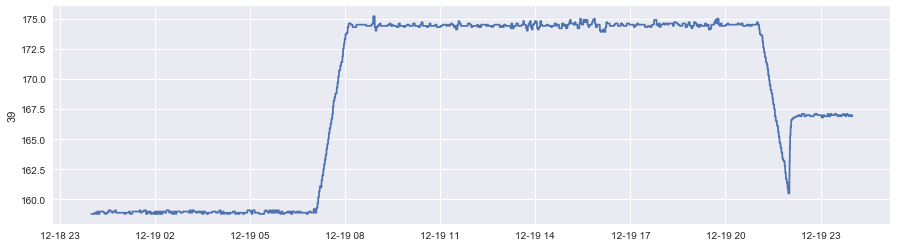

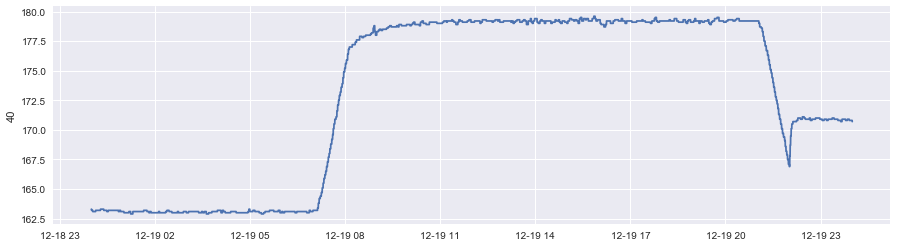

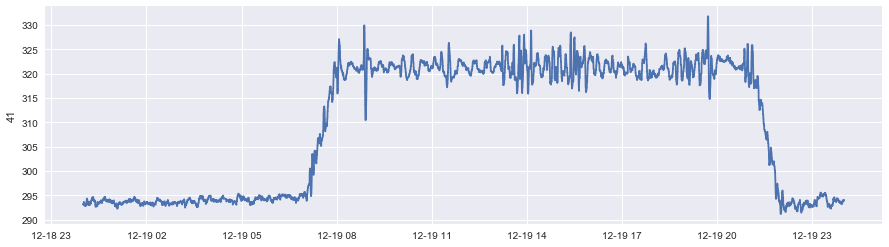

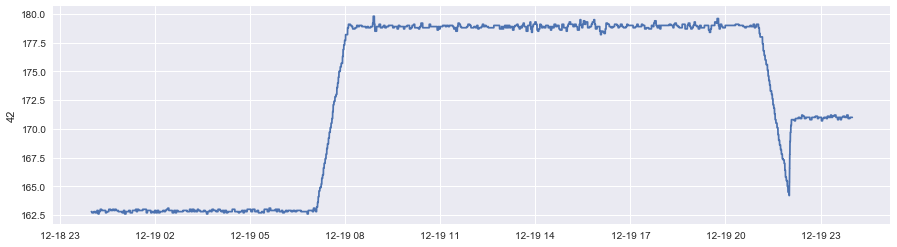

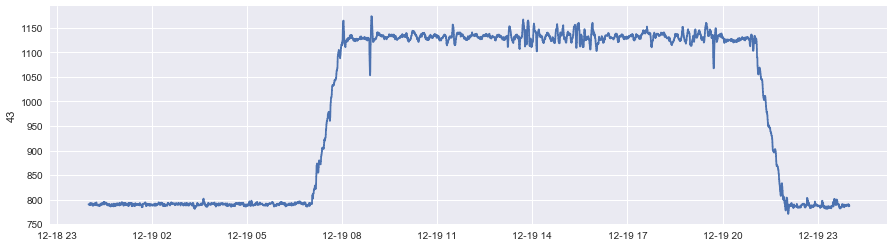

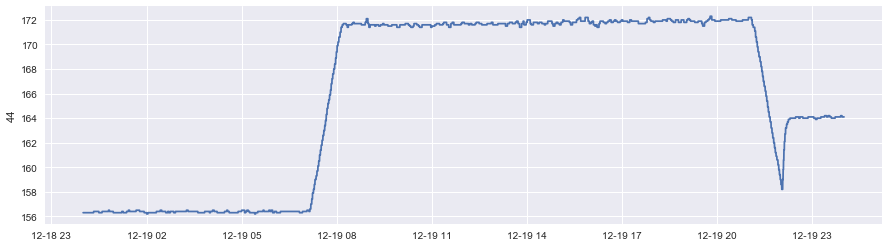

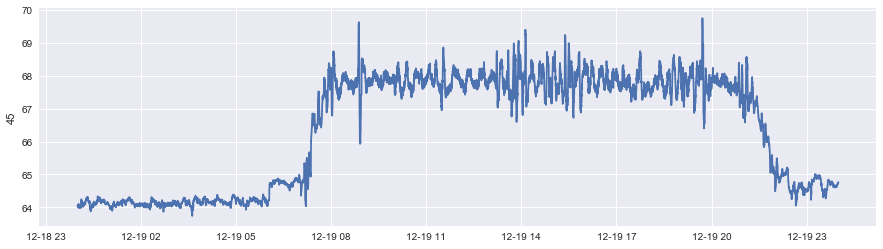

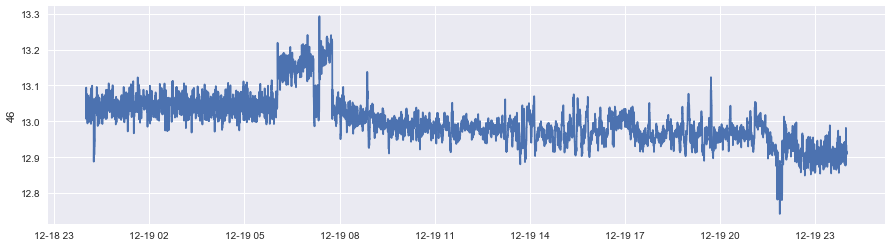

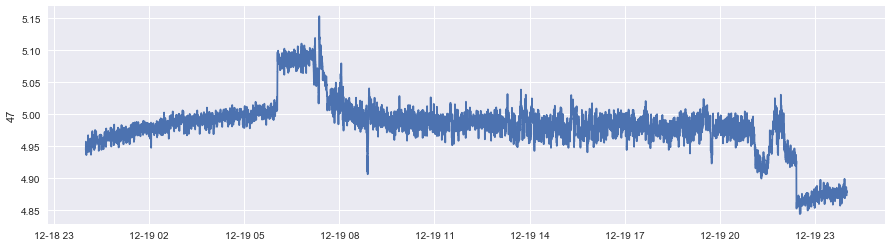

In [161]:
dataset = pd.read_csv('20131219.csv',sep=';', skiprows=1, header=None).rename(columns=lambda x:  x + 1)
dataset['TIME'] = dataset.iloc[:,1].map(lambda x: str(x)[:-4])
dataset['DATE'] = dataset.iloc[:,0]
dataset['dt'] =  pd.to_datetime(dataset['DATE'] + ' ' + dataset['TIME'], dayfirst = True)
dataset.set_index('dt',inplace=True)
dataset = dataset.iloc[:, 2:47]
dataset = dataset.apply(lambda x: x.str.replace(',','.'))
dataset = dataset.astype('float64', raise_on_error = False)
for i in range(0,45):
    plt.figure(figsize(15,4))
    plt.plot(dataset.iloc[:,i],)
    plt.ylabel(str(i+3))
    pylab.show()

In [2]:
filenames = sorted(glob.glob('2013*.csv'))
frame = pd.DataFrame()
for f in filenames:
    dr = pd.read_csv(f,sep=';', skiprows=1, header=None).rename(columns=lambda x:  x + 1)
    dr['TIME'] = dr.iloc[:,1].map(lambda x: str(x)[:-4])
    dr['DATE'] = dr.iloc[:,0]
    dr['dt'] =  pd.to_datetime(dr['DATE'] + ' ' + dr['TIME'], dayfirst = True)
    dr.set_index('dt',inplace=True)
    dr = dr.iloc[:, 2:47]
    dr = dr.apply(lambda x: x.str.replace(',','.'))
    dr = dr.astype('float64', raise_on_error = False)
    frame = pd.concat([frame, dr])
df=frame

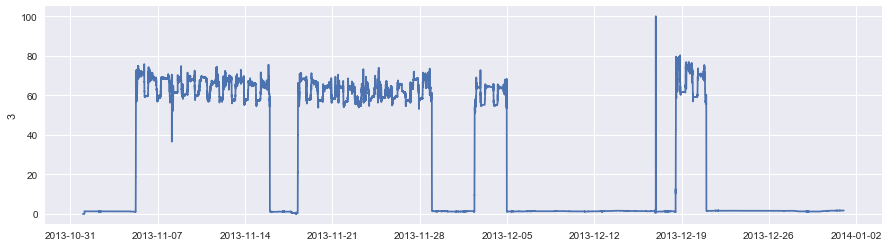

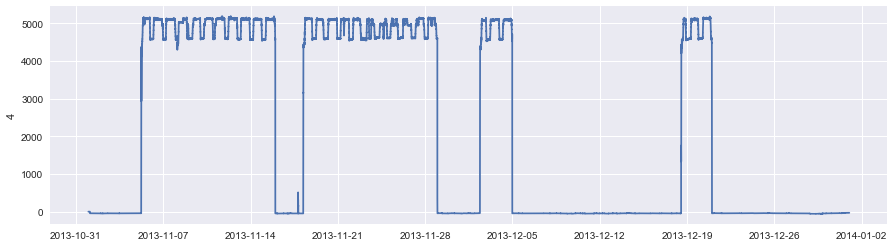

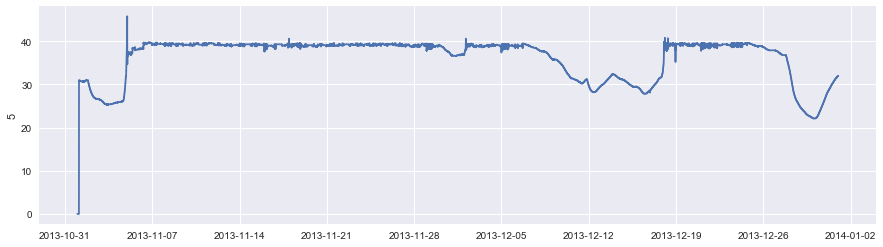

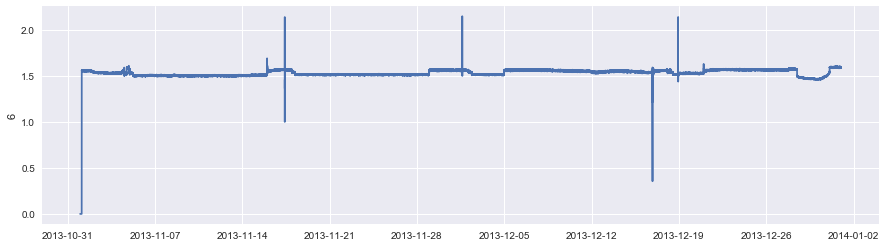

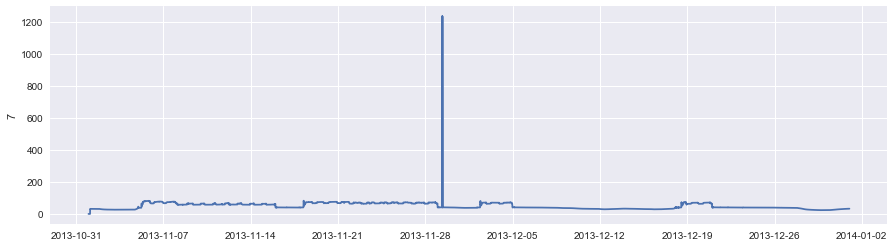

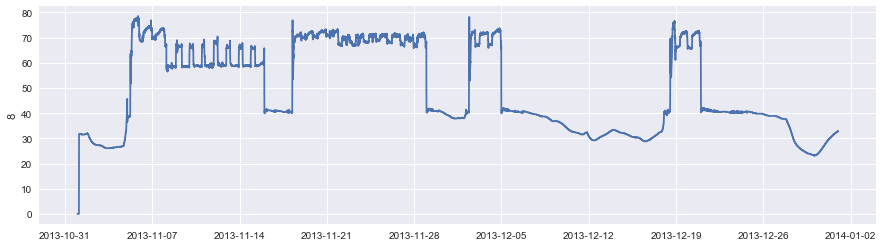

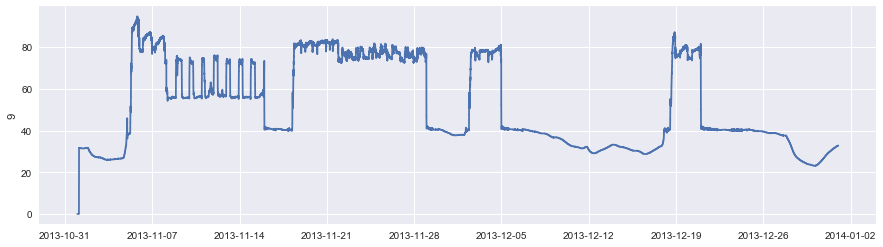

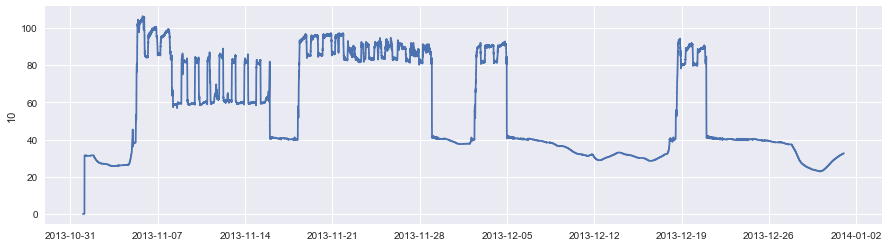

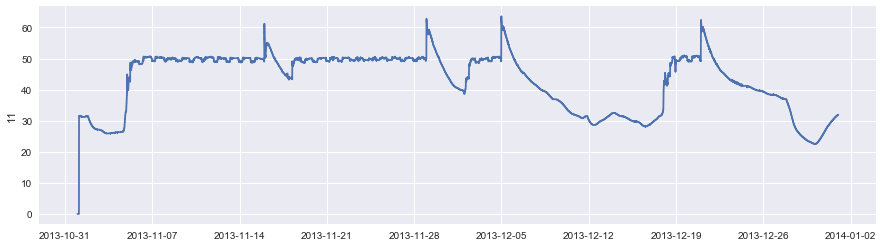

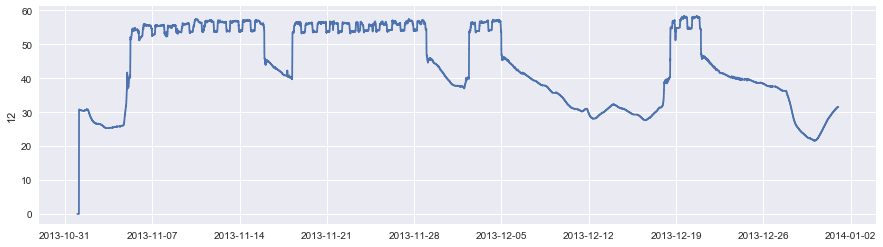

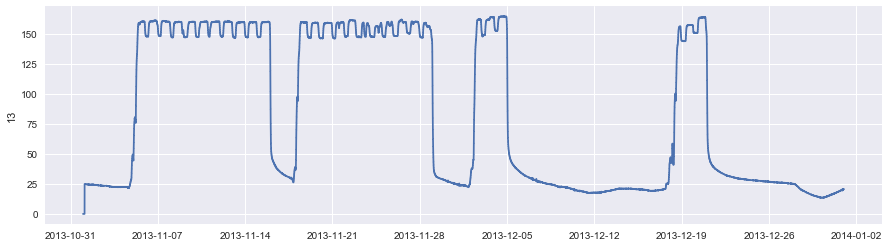

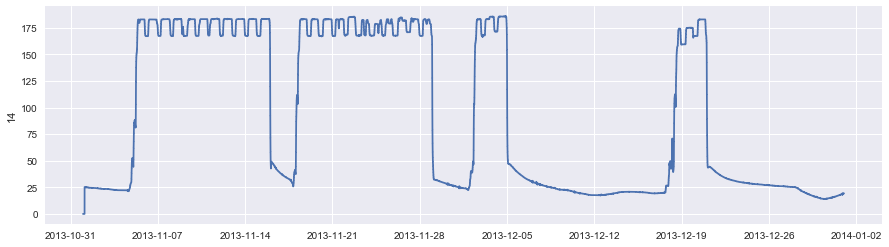

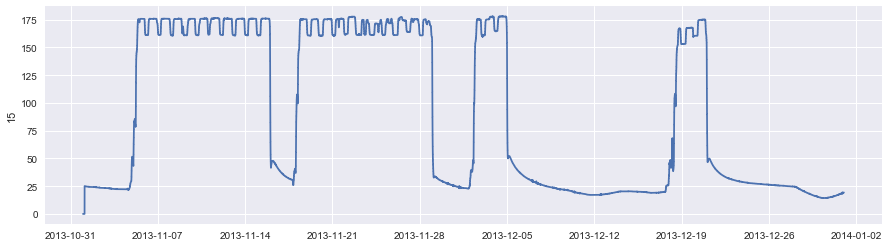

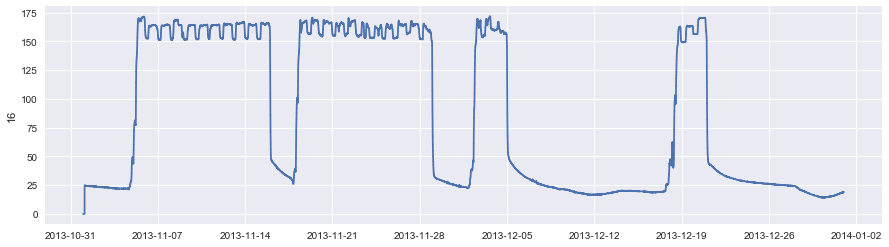

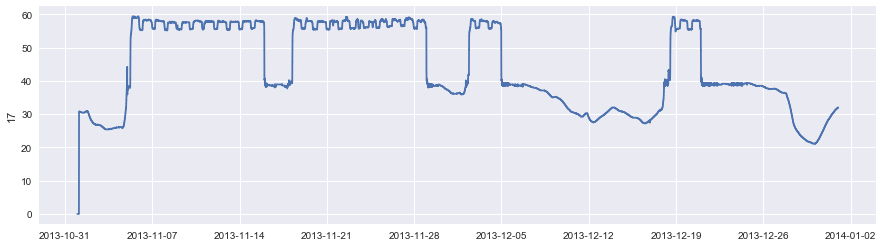

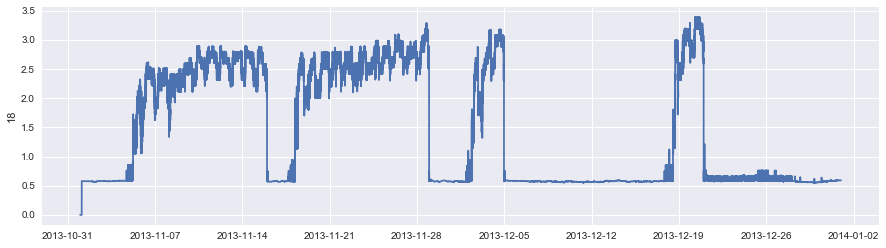

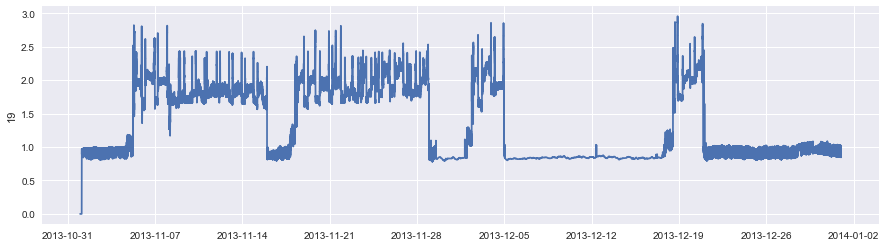

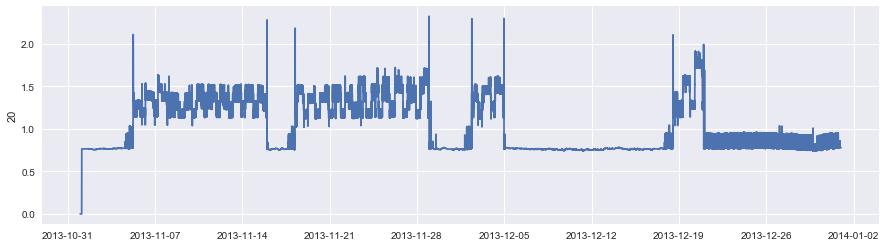

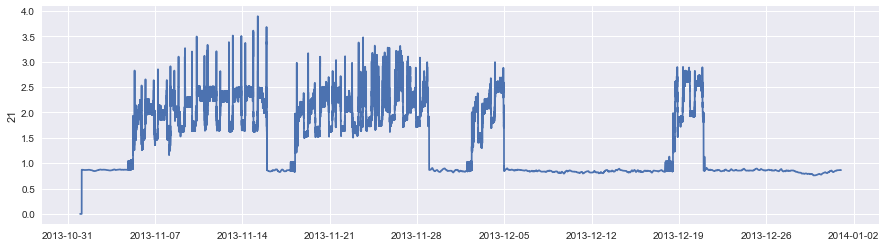

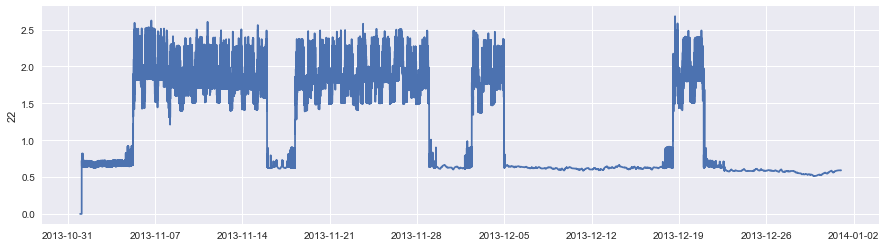

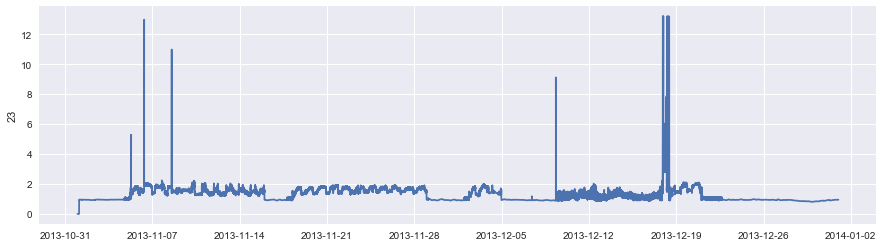

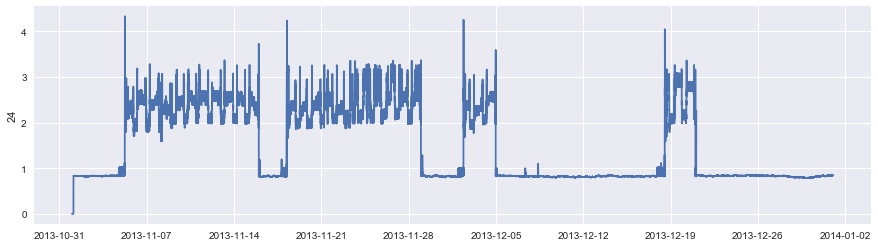

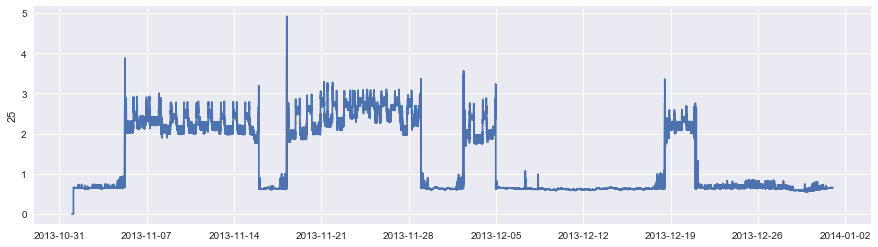

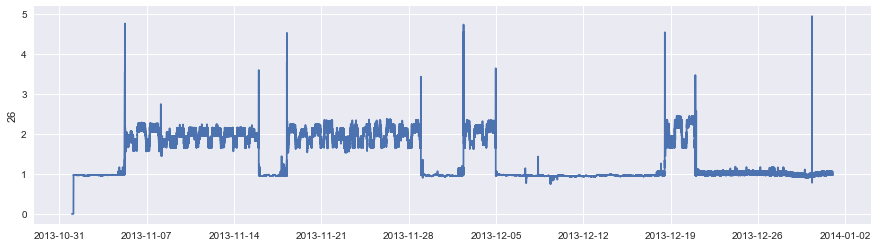

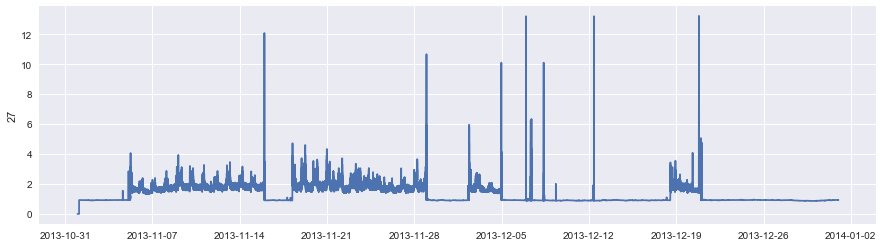

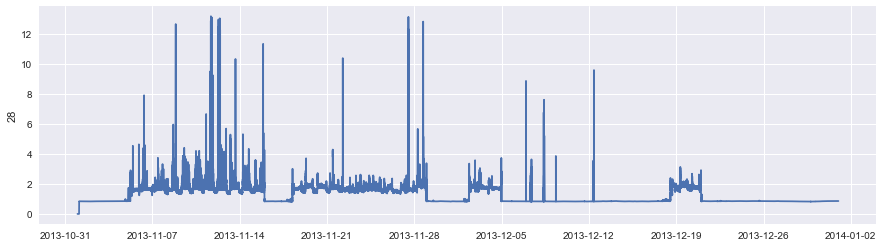

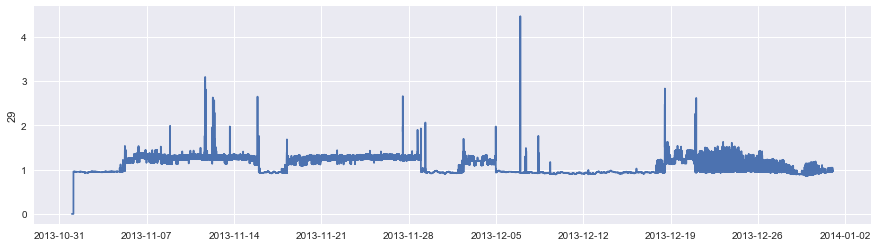

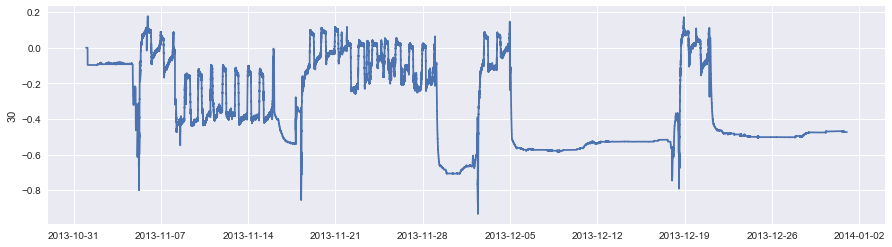

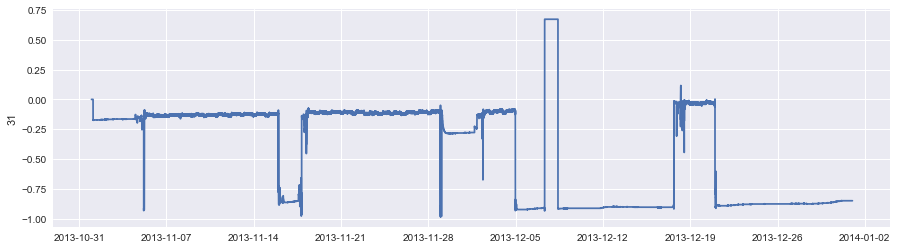

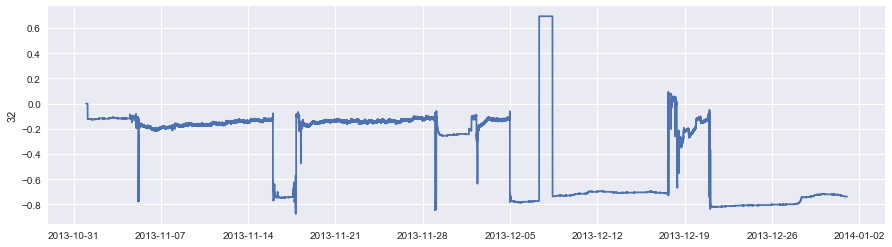

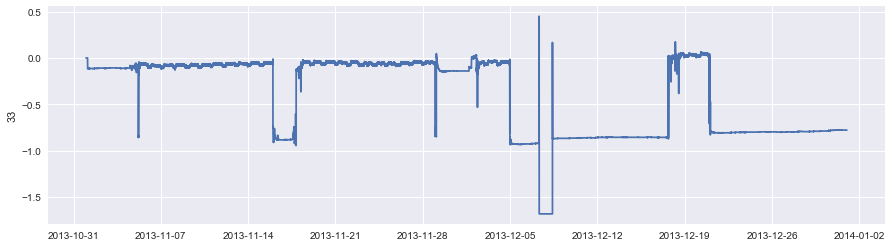

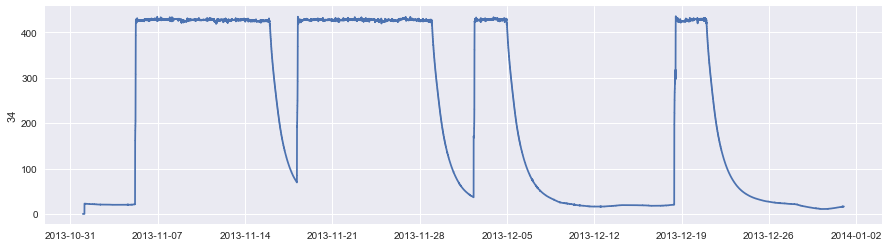

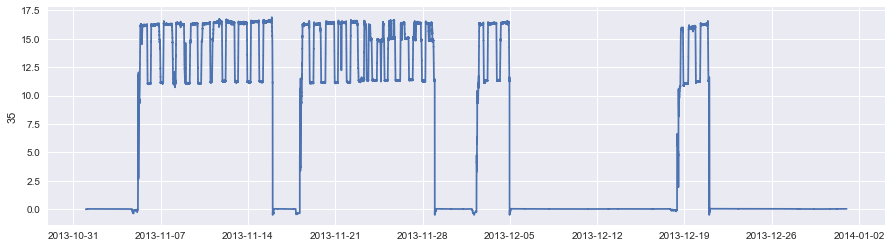

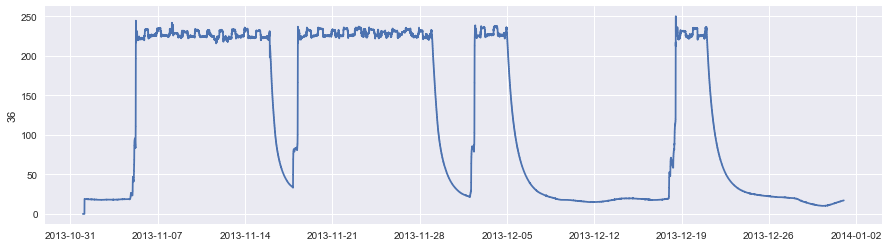

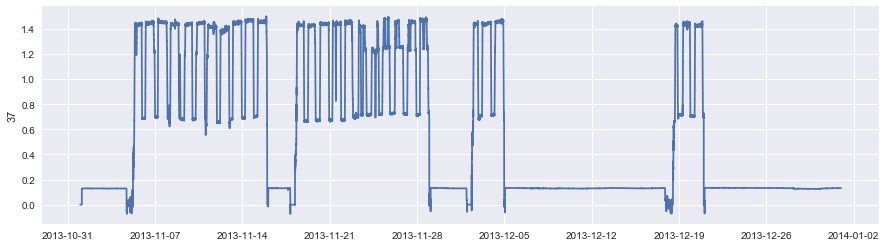

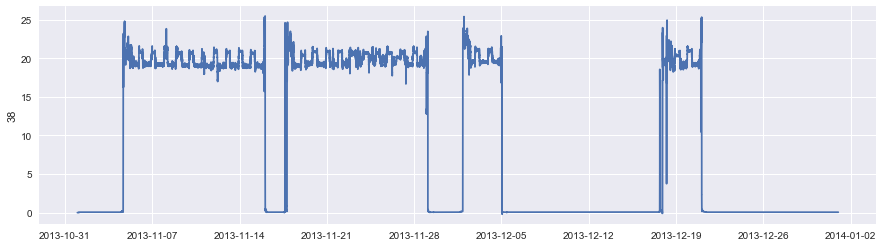

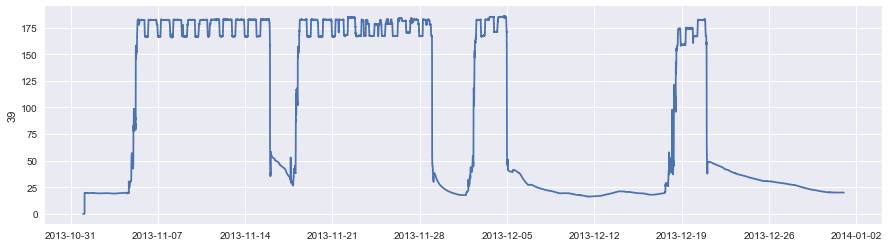

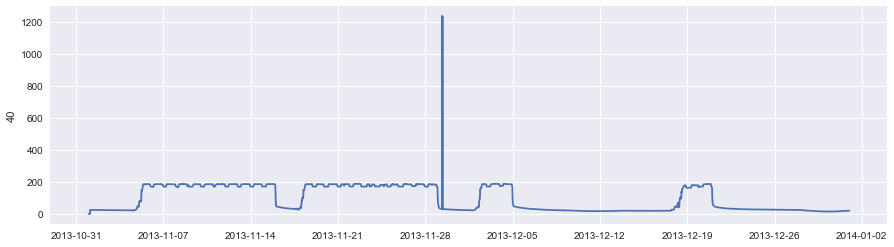

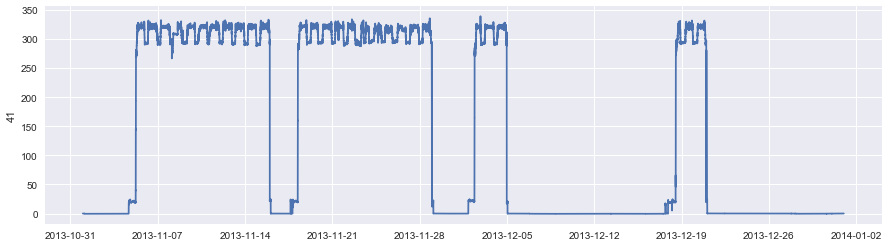

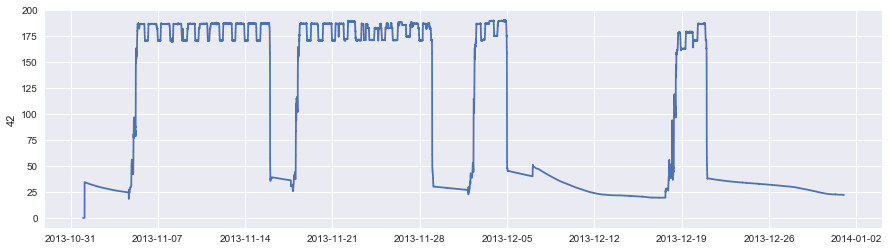

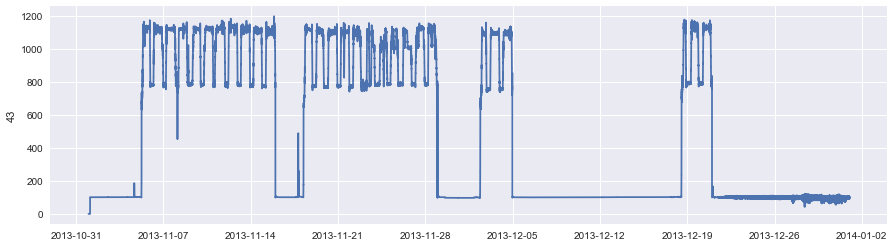

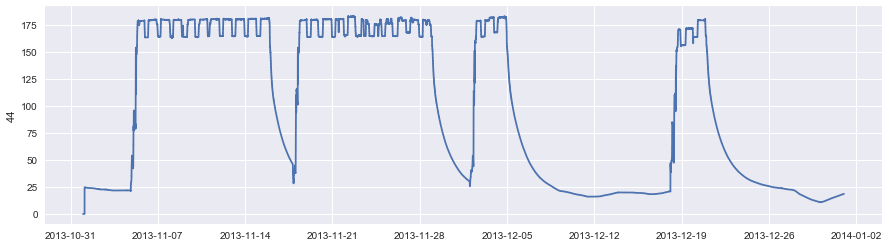

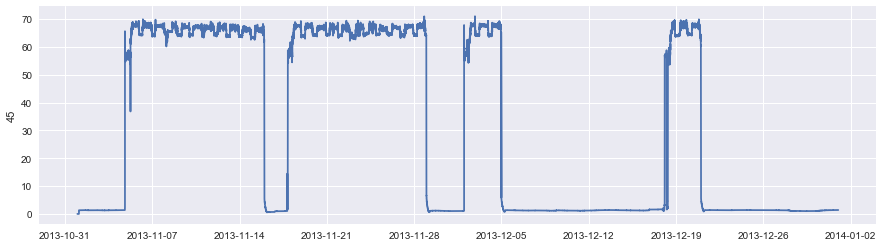

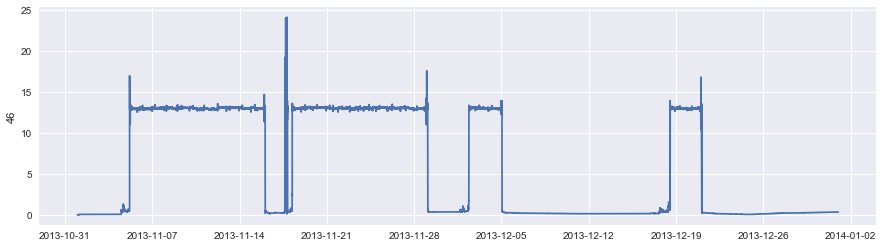

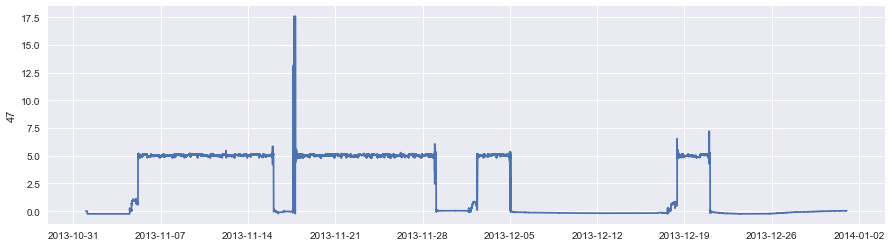

In [162]:
for i in range(0,45):
    plt.figure(figsize(15,4))
    plt.plot(df.iloc[:,i],)
    plt.ylabel(str(i+3))
    pylab.show()

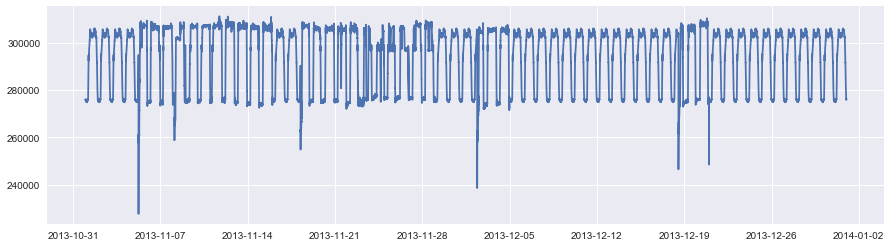

In [163]:
dfM = df.resample('T').sum()
dfM[(dfM.iloc[:,1] < 3700*60) | (dfM.iloc[:,40] < 135*60)] = NaN
dfM['time'] = dfM.index.time
df4 = dfM.groupby("time").transform(lambda x: x.fillna(x.mean()))
df4['values_4'] = df4.iloc[:,1]
plt.figure(figsize(15,4))
plt.plot(df4.values_4)
pylab.show()

In [ ]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [164]:
from sklearn.model_selection import TimeSeriesSplit

# Кросс-валидация
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=6) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 60*24, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [148]:
%%time
data = df4.values_4
values = data.values
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем:
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.000487535185363 1.92092748474e-06 0.016320060619
Wall time: 34min 44s


(60000, 80000)

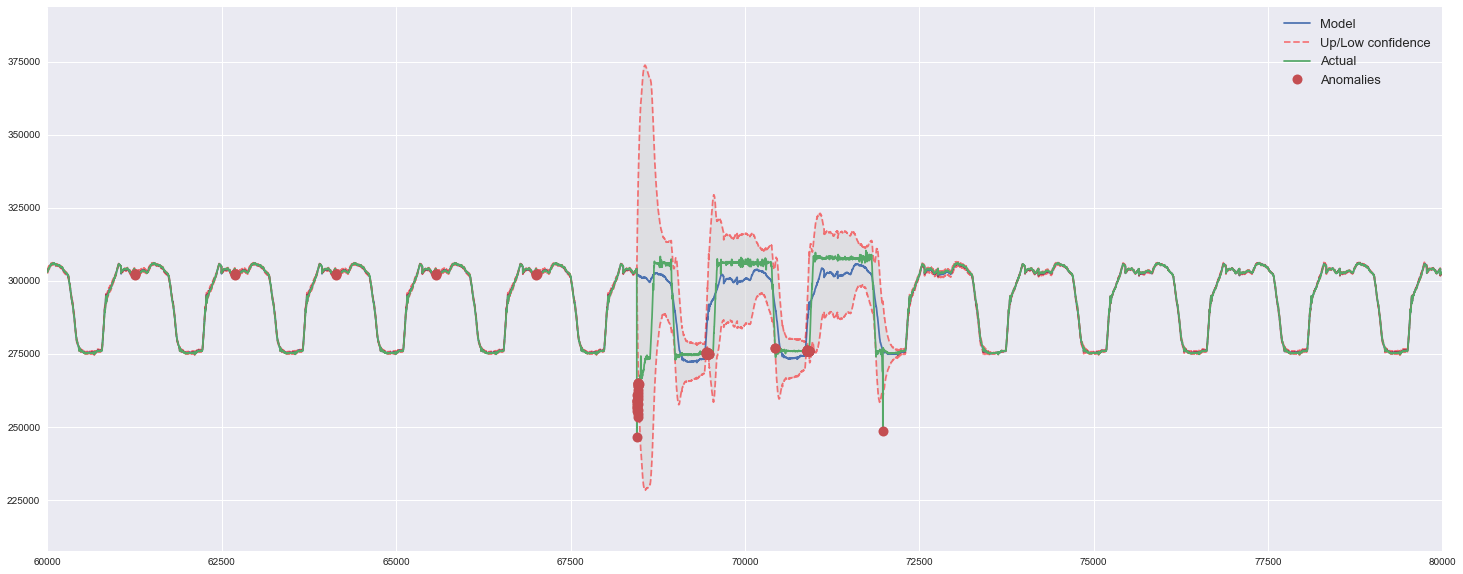

In [171]:
data = df4.values_4
model = HoltWinters(data[:-60], slen = 60*24, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 60, scaling_factor = 2.56)
model.triple_exponential_smoothing()

Anomalies = np.array([np.NaN]*len(data))
Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
plt.figure(figsize=(25, 10))
plt.plot(model.result, label = "Model")
plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(model.LowerBond, "r--", alpha=0.5)
plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5,color = "lightgrey")
plt.plot(data.values, label = "Actual")
plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);
ax = plt.gca()
ax.set_xlim(60000,80000)


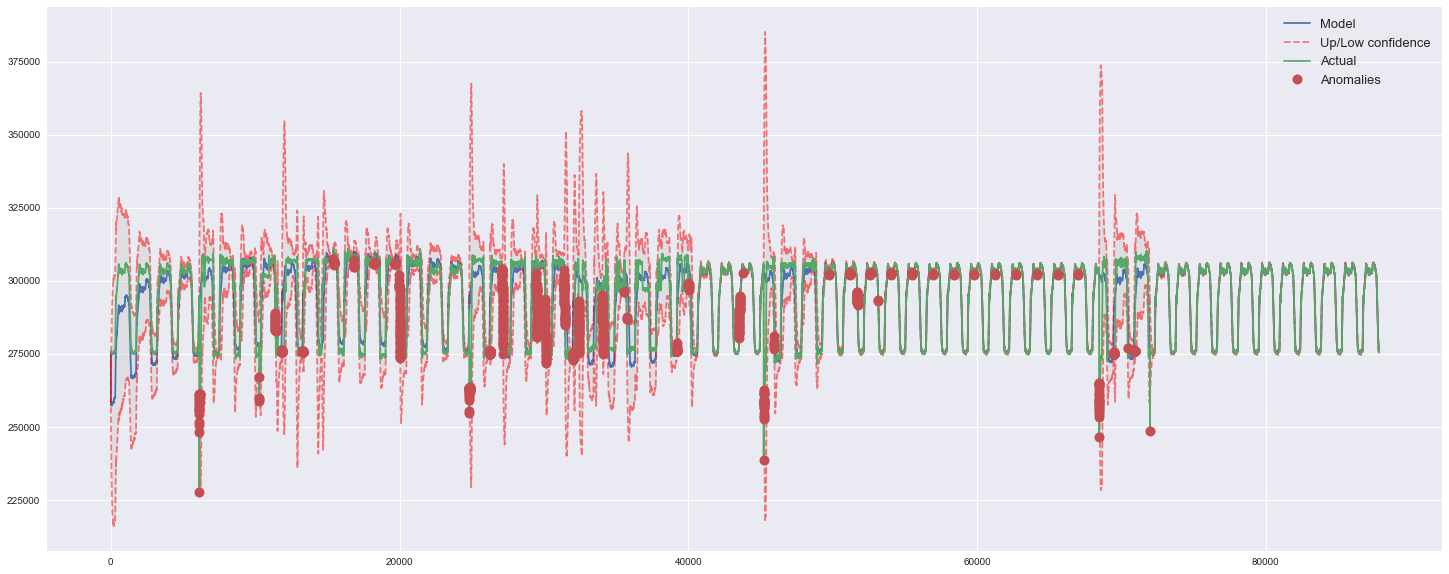

In [172]:
Anomalies = np.array([np.NaN]*len(data))
Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
plt.figure(figsize=(25, 10))
plt.plot(model.result, label = "Model")
plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(model.LowerBond, "r--", alpha=0.5)
plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "lightgrey")
plt.plot(data.values, label = "Actual")
plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
#plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);

In [174]:
dfM = df.resample('T').sum()
df4 = dfM
df4[(df4.iloc[:,1] < 3700*60) | (df4.iloc[:,40] < 135*60)] = 0
df4 = df4.resample('D').sum()
lst = df4[(df4.iloc[:,1] > 0)].index.date.tolist()
dfM[(dfM.iloc[:,1] < 3700*60) | (dfM.iloc[:,40] < 135*60)] = NaN
dfM['time'] = dfM.index.time
dfM = dfM.groupby('time').transform(lambda x: x.fillna(x.mean()))
dfM['values_4'] = dfM.iloc[:,1]
dfM['date'] = dfM.index.date
dfM['time'] = dfM.index.time

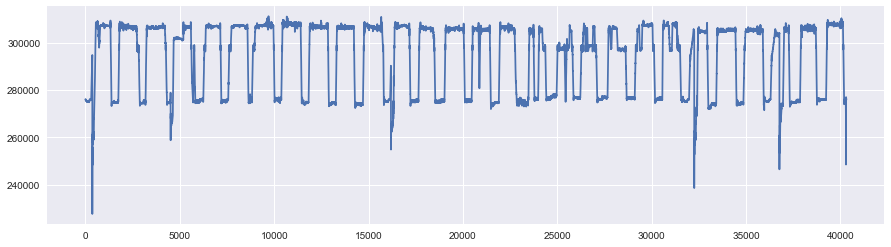

In [175]:
dfM1 = dfM.loc[dfM['date'].isin(lst)]
dfM1 = dfM1.reset_index()
plt.figure(figsize(15,4))
plt.plot(dfM1.values_4)

In [143]:
%%time
data = dfM1.values_4
values = data.values
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем:
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.00067926903828 0.000511551783171 0.0570820559998
Wall time: 16min 3s


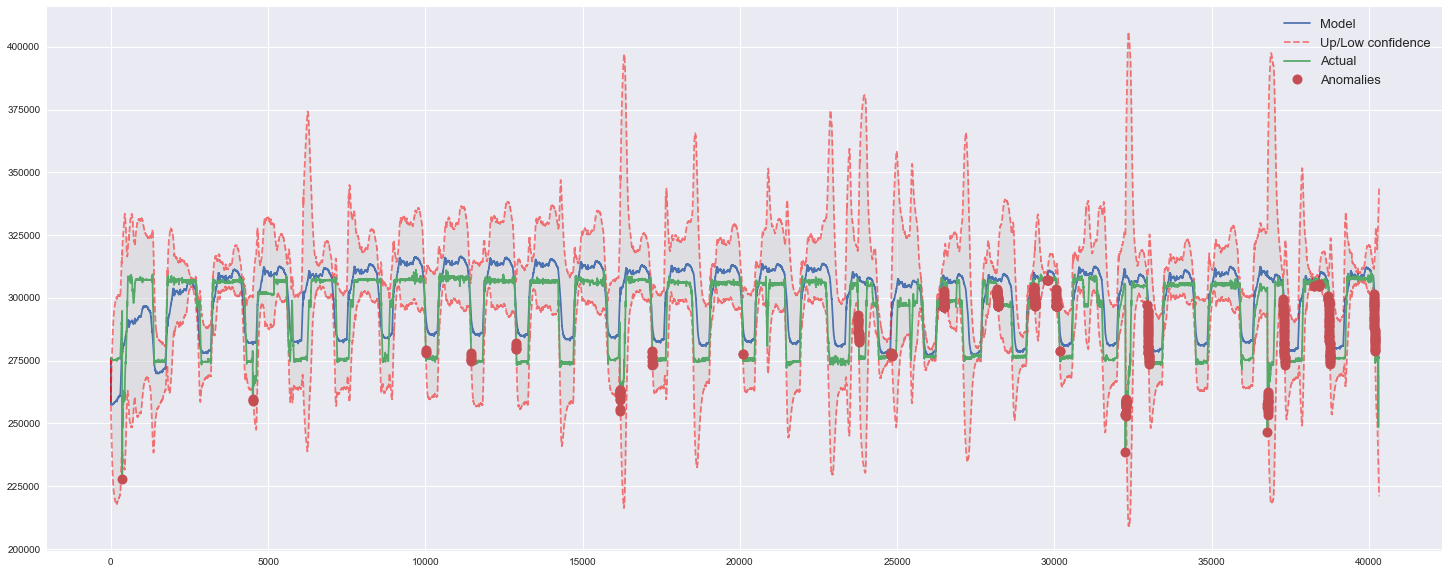

In [176]:
data = dfM1.values_4
model = HoltWinters(data[:-60], slen = 60*24, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 60, scaling_factor = 2.56)
model.triple_exponential_smoothing()
Anomalies = np.array([np.NaN]*len(data))
Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
plt.figure(figsize=(25, 10))
plt.plot(model.result, label = "Model")
plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(model.LowerBond, "r--", alpha=0.5)
plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "lightgrey")
plt.plot(data.values, label = "Actual")
plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);